In [281]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from processing import *
from vectorizing import *

from keras.preprocessing.sequence import pad_sequences
from keras import models
from keras import layers

from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Read the Data into Dataframe Variables

### Read the training data

In [282]:
# read csv file into dataframe variable
df_train = pd.read_csv('../data/train.csv')

In [283]:
# check the size of the dataframe
df_train.shape

(7613, 5)

In [284]:
# view the first 5 rows of the dataframe
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [285]:
# read cvs file into dataframe variables
df_test = pd.read_csv('../data/test.csv')
df_test_copy = df_test.copy()

In [286]:
# check the size of the dataframe
df_test.shape

(3263, 4)

In [287]:
# view the first 5 rows of the dataframe
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Clean Data

### Clean train data

In [288]:
# drop id, keyword, and location features/columns
df_train.drop(columns = ['id', 'keyword', 'location'], inplace=True)

In [289]:
# check for NaN values in the text and target features
df_train.isnull().sum()

text      0
target    0
dtype: int64

### Clean test data

In [290]:
# drop id, keyword, and location features/columns
df_test.drop(columns = ['id', 'keyword', 'location'], inplace=True)

In [291]:
# check for NaN values in the text and target features
df_test.isnull().sum()

text    0
dtype: int64

# Preprocess text data

### Preprocess train text

In [292]:
# call the process_text function from the processing.py file
# save the output into a new dataframe
df_train_clean = process_text(df_train)

In [293]:
# view the first 5 rows of the dataframe
df_train_clean.head()

,text,target
0,deeds reason earthquake may forgive us,1
1,forest fire near la,1
2,residents asked shelter place notified officer...,1
3,people receive wildfires evacuation orders,1
4,got sent photo ruby smoke wildfires pours school,1


### Preprocess test text

In [294]:
# call the process_text function from the processing.py file
# save the output into a new dataframe
df_test_clean = process_text(df_test)

In [295]:
# view the first 5 rows of the dataframe
df_test_clean.head()

,text
0,happened terrible car crash
1,heard earthquake different cities stay safe ev...
2,forest fire spot pond geese fleeing across str...
3,apocalypse lighting wildfires
4,typhoon kills china


# Vectorize the text using CountVectorizer

### Vectorize the train text

In [296]:
# one-hot encode and generate the dataframe with features as words
term_df_train = vectorize_df(df_train)

In [297]:
# view first 5 rows of the dataframe, (rows, columns)
term_df_train.shape

(7613, 8697)

In [298]:
# add the target feature/column from the train data
term_df_train['target'] = df_train_clean['target']

In [299]:
# view counts for each feature/column/word
term_df_train.sum(axis=0).sort_values(ascending=False)

target       3271
like          346
amp           300
fire          254
get           229
             ... 
midweek         1
migraine        1
migrating       1
mil             1
ab              1
Length: 8697, dtype: int64

### Vectorize the test text

In [300]:
# one-hot encode and generate the dataframe with features as words
term_df_test = vectorize_df(df_test)

In [301]:
# view first 5 rows of the dataframe, (rows, columns)
term_df_test.shape

(3263, 5796)

In [302]:
# view counts for each feature/column/word
term_df_test.sum(axis=0).sort_values(ascending=False)

like          145
amp           136
fire          109
get           108
via           104
             ... 
motorways       1
motors          1
motorcycle      1
mothers         1
liberals        1
Length: 5796, dtype: int64

# Baseline

In [303]:
# if we predicted everything to be 1, disaster, the accuracy would be 0.4296
df_train['target'].value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

# Models

## Neural Network

### Create Tensors from Train Data

In [389]:
# prepare the tensors for the neural network
# tensor = multidimensional numpy array, ndarray in Python
train_labels = term_df_train['target'] # series
train_data = term_df_train.copy() # dataframe
train_data.drop(columns='target', inplace=True)
train_data = train_data.to_numpy() # ndarray

In [390]:
# create the tensors
x_train = pad_sequences(train_data, padding='post', maxlen=10000) # ndarray of length 10000
y_train = np.asarray(train_labels).astype('float32') # ndarray

### Split the data into train and validation/test

In [391]:
# create training and validation/testing data to feed into the neural network
partial_x_train, x_val, partial_y_train, y_val = train_test_split(x_train, y_train, random_state=0, stratify=y_train)

In [392]:
# check the shape of the tensors
x_val.shape, partial_x_train.shape, y_val.shape, partial_y_train.shape

((1904, 10000), (5709, 10000), (1904,), (5709,))

### Build, Train, and Evaluate the Model

In [308]:
# build the model
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10_000, ))) # , input layer, input shape needs to match the length of the x data tensor
model.add(layers.Dense(16, activation='relu')) # intermediate layer, hidden layer
model.add(layers.Dense(1, activation='sigmoid')) # output layer

In [309]:
# compile the model
# need to specify optimizer, loss function, and evaluation metric
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [310]:
# fit/train the model on the train data, and evaluate/test on the validation/test data
# need to specify train data, number of epochs, batch size, and validation data
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/20
12/12 [==============================] - 0s 34ms/step - loss: 0.6768 - acc: 0.6520 - val_loss: 0.6522 - val_acc: 0.7190
Epoch 2/20
12/12 [==============================] - 0s 23ms/step - loss: 0.6193 - acc: 0.7954 - val_loss: 0.6062 - val_acc: 0.7768
Epoch 3/20
12/12 [==============================] - 0s 22ms/step - loss: 0.5579 - acc: 0.8399 - val_loss: 0.5658 - val_acc: 0.7878
Epoch 4/20
12/12 [==============================] - 0s 22ms/step - loss: 0.4990 - acc: 0.8609 - val_loss: 0.5327 - val_acc: 0.7994
Epoch 5/20
12/12 [==============================] - 0s 24ms/step - loss: 0.4455 - acc: 0.8765 - val_loss: 0.5061 - val_acc: 0.7973
Epoch 6/20
12/12 [==============================] - 0s 20ms/step - loss: 0.3967 - acc: 0.8886 - val_loss: 0.4859 - val_acc: 0.8004
Epoch 7/20
12/12 [==============================] - 0s 26ms/step - loss: 0.3537 - acc: 0.8981 - val_loss: 0.4738 - val_acc: 0.8057
Epoch 8/20
12/12 [==============================] - 0s 22ms/step - loss: 0.3161 - a

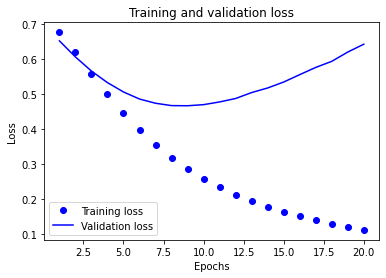

In [311]:
# plot the training and validation/test loss
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']

epochs = range(1, len(acc_values)+1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

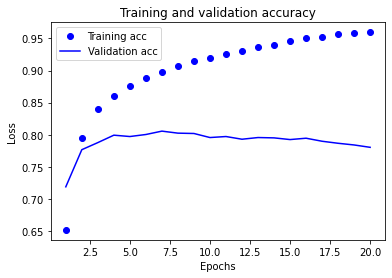

In [312]:
# plot the training and validation/test accuracy
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [313]:
# re-train the model with a number of epochs based on where we see the lowest loss and highest accuracy for the validation data (check plots above)
history = model.fit(partial_x_train, partial_y_train, epochs=9, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/9
12/12 [==============================] - 0s 22ms/step - loss: 0.1047 - acc: 0.9616 - val_loss: 0.6649 - val_acc: 0.7815
Epoch 2/9
12/12 [==============================] - 0s 20ms/step - loss: 0.0983 - acc: 0.9636 - val_loss: 0.6983 - val_acc: 0.7831
Epoch 3/9
12/12 [==============================] - 0s 20ms/step - loss: 0.0929 - acc: 0.9644 - val_loss: 0.7221 - val_acc: 0.7820
Epoch 4/9
12/12 [==============================] - 0s 20ms/step - loss: 0.0878 - acc: 0.9679 - val_loss: 0.7486 - val_acc: 0.7815
Epoch 5/9
12/12 [==============================] - 0s 20ms/step - loss: 0.0833 - acc: 0.9672 - val_loss: 0.7711 - val_acc: 0.7731
Epoch 6/9
12/12 [==============================] - 0s 21ms/step - loss: 0.0794 - acc: 0.9700 - val_loss: 0.8005 - val_acc: 0.7736
Epoch 7/9
12/12 [==============================] - 0s 21ms/step - loss: 0.0754 - acc: 0.9713 - val_loss: 0.8357 - val_acc: 0.7726
Epoch 8/9
12/12 [==============================] - 0s 21ms/step - loss: 0.0722 - acc: 0.97

### Create Tensor from Kaggle Test Data

In [379]:
# prepare the tensors for the neural network
# tensor = multidimensional numpy array, ndarray in Python
test_data = term_df_test.copy() # dataframe
test_data = test_data.to_numpy() # ndarray

In [386]:
# create the tensors
x_test = pad_sequences(test_data, padding='post', maxlen=10000) # ndarray of length 10000

In [387]:
# check the shape of the tensors
x_test.shape

(3263, 10000)

### Get predictions from Kaggle Test Data

In [317]:
# get predictions for test data
preds = model.predict(x_test)
preds

array([[0.00360692],
       [0.00740799],
       [0.99969256],
       ...,
       [0.010593  ],
       [0.67529666],
       [0.7786255 ]], dtype=float32)

In [318]:
# map values less that 0.5 to 0 and values higher than 0.5 to 1
y_test = (preds < 0.5).astype(np.int)
y_test

array([[1],
       [1],
       [0],
       ...,
       [1],
       [0],
       [0]])

### Create Submission File for Kaggle

In [319]:
# add all test data into submission, and drop the features/columns not needed
# submission columns are id and target
submission = df_test_copy.copy()
submission.drop(columns=['keyword', 'location', 'text'], inplace=True)

In [320]:
# add the target column to the submission dataframe
submission['target'] = y_test

In [321]:
# save the submission dataframe into a csv file, then upload the file on the Kaggle website
# https://www.kaggle.com/c/nlp-getting-started/submit
submission.to_csv('../data/submission.csv', index=False)

In [322]:
# Baseline = 0.42966
# Kaggle score = 0.46797

## Multinomial Naive Bayes

In [367]:
y = term_df_train['target']
x = term_df_train.copy()
x.drop(columns='target', inplace=True)

### Split the data into train and validation/test

In [368]:
# create training and validation/testing data to feed into the neural network
partial_x_train, x_val, partial_y_train, y_val = train_test_split(x_train, y_train, random_state=0, stratify=y)

In [393]:
# check the shape of the tensors
x_val.shape, partial_x_train.shape, y_val.shape, partial_y_train.shape

((1904, 10000), (5709, 10000), (1904,), (5709,))

In [394]:
model = MultinomialNB()
model.fit(partial_x_train, partial_y_train)
print(model.score(x_val, y_val))

0.7904411764705882


In [395]:
preds_val = model.predict(x_val)

In [396]:
metrics.f1_score(y_val, preds_val)

0.7427466150870407

### Get predictions from Kaggle Test Data

In [397]:
# get predictions for test data
preds = model.predict(x_test)
preds

array([0., 0., 1., ..., 0., 1., 0.], dtype=float32)

In [398]:
# map values less that 0.5 to 0 and values higher than 0.5 to 1
y_test = (preds < 0.5).astype(np.int)
y_test

array([1, 1, 0, ..., 1, 0, 1])

### Create Submission File for Kaggle

In [399]:
# add all test data into submission, and drop the features/columns not needed
# submission columns are id and target
submission_nb = df_test_copy.copy()
submission_nb.drop(columns=['keyword', 'location', 'text'], inplace=True)

In [400]:
# add the target column to the submission dataframe
submission_nb['target'] = y_test

In [401]:
# save the submission dataframe into a csv file, then upload the file on the Kaggle website
# https://www.kaggle.com/c/nlp-getting-started/submit
submission_nb.to_csv('../data/submission_nb.csv', index=False)

In [ ]:
# Baseline = 0.42966
# Kaggle score = 0.46858

## Multinomial Naive Bayes with GridSearch

### Split the data into train and validation/test

In [354]:
x = df_train['text']
y = df_train['target']

In [355]:
# create training and validation/testing data to feed into the neural network
partial_x_train, x_val, partial_y_train, y_val = train_test_split(x, y, random_state=0, stratify=y)

In [356]:
# check the shape of the tensors
x_val.shape, partial_x_train.shape, y_val.shape, partial_y_train.shape

((1904,), (5709,), (1904,), (5709,))

In [357]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [358]:
pipe_params = {'cvec__max_features':[2000, 3000, 4000],
               'cvec__min_df':[2, 3],
               'cvec__max_df':[.90, .95],
               'cvec__ngram_range':[(1,1), (1,2)]
                }

In [359]:
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [360]:
gs = GridSearchCV(pipe
                  , pipe_params
                  , cv=cv_folds 
                  , verbose=1
                  , n_jobs=4
                 )

In [361]:
gs.fit(partial_x_train, partial_y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    3.4s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=4,
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]},
             verbose=1)

In [362]:
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 4000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2)}

In [363]:
preds_val = gs.predict(x_val)

In [364]:
metrics.accuracy_score(y_val, preds_val)

0.8025210084033614

In [365]:
metrics.f1_score(y_val, preds_val)

0.7473118279569894

### Get predictions from Kaggle Test Data

In [366]:
# get predictions for test data
preds = gs.predict(df_test['text'])
preds

array([1, 0, 1, ..., 1, 1, 1])

### Create Submission File for Kaggle

In [ ]:
# add all test data into submission, and drop the features/columns not needed
# submission columns are id and target
submission_gs = df_test_copy.copy()
submission_gs.drop(columns=['keyword', 'location', 'text'], inplace=True)

In [ ]:
# add the target column to the submission dataframe
submission_gs['target'] = y_test

In [ ]:
# save the submission dataframe into a csv file, then upload the file on the Kaggle website
# https://www.kaggle.com/c/nlp-getting-started/submit
submission_gs.to_csv('../data/submission_gs.csv', index=False)

In [ ]:
# Baseline = 0.42966
# Kaggle score = 0.23046

## Neural Network (experiment with layers)

### Create Tensors from Train Data

In [ ]:
# prepare the tensors for the neural network
# tensor = multidimensional numpy array, ndarray in Python
train_labels = term_df_train['target'] # series
train_data = term_df_train.copy() # dataframe
train_data.drop(columns='target', inplace=True)
train_data = train_data.to_numpy() # ndarray

In [ ]:
# create the tensors
x_train = pad_sequences(train_data, padding='post', maxlen=10000) # ndarray of length 10000
y_train = np.asarray(train_labels).astype('float32') # ndarray

In [ ]:
# create training and validation/testing data to feed into the neural network
partial_x_train, x_val, partial_y_train, y_val = train_test_split(x_train, y_train, random_state=0, stratify=y_train)

### Create Tensor from Kaggle Test Data

In [ ]:
# prepare the tensors for the neural network
# tensor = multidimensional numpy array, ndarray in Python
test_data = term_df_test.copy() # dataframe
test_data = test_data.to_numpy() # ndarray

In [ ]:
# create the tensors
x_test = pad_sequences(test_data, padding='post', maxlen=10000) # ndarray of length 10000

In [ ]:
# check the shape of the tensors
x_test.shape

### Split Data into Train and Validation/Test

In [ ]:
# check the shape of the tensors
x_val.shape, partial_x_train.shape, y_val.shape, partial_y_train.shape

### Build, Train, and Evaluate the Model

In [ ]:
# build the model
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(10_000, ))) # , input layer, input shape needs to match the length of the x data tensor
model.add(layers.Dense(32, activation='relu')) # intermediate layer, hidden layer
model.add(layers.Dense(1, activation='sigmoid')) # output layer

In [ ]:
# compile the model
# need to specify optimizer, loss function, and evaluation metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
# fit/train the model on the train data, and evaluate/test on the validation/test data
# need to specify train data, number of epochs, batch size, and validation data
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

In [ ]:
# plot the training and validation/test loss
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']

epochs = range(1, len(acc_values)+1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# plot the training and validation/test accuracy
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# re-train the model with a number of epochs based on where we see the lowest loss and highest accuracy for the validation data (check plots above)
history = model.fit(partial_x_train, partial_y_train, epochs=5, batch_size=512, validation_data=(x_val, y_val))

### Get predictions from Kaggle Test Data

In [ ]:
# get predictions for test data
preds = model.predict(x_test)
preds

In [ ]:
# map values less that 0.5 to 0 and values higher than 0.5 to 1
y_test = (preds < 0.5).astype(np.int)
y_test

### Create Submission File for Kaggle

In [ ]:
# add all test data into submission, and drop the features/columns not needed
# submission columns are id and target
submission_nn = df_test_copy.copy()
submission_nn.drop(columns=['keyword', 'location', 'text'], inplace=True)

In [ ]:
# add the target column to the submission dataframe
submission_nn['target'] = y_test

In [ ]:
# save the submission dataframe into a csv file, then upload the file on the Kaggle website
# https://www.kaggle.com/c/nlp-getting-started/submit
submission_nn.to_csv('../data/submission_nn.csv', index=False)

In [ ]:
# Baseline = 0.42966
# Kaggle score = 0.44836

# Conclusion

The Neural Network and Naive Bayes models performed best.

Neural Networks requires very large amount of data, so they may not be the best option for working with this dataset.